# Capstone Project - The best place for a beer shop
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Last weekend I met my old friend from Moscow (capital of Russian Federation). That evening was amazing we haven’t met for three years. We talked some hours about our jobs, personal file and ideas about our future plans. Eventually he told me that he wants to start his own business. His choose is some strange for me because his is an engineer and wants to open a **beer shop**. 

I decided to help him by using data science power.  

The city has a lot of districts. These are so different to start his own business. I try to find the best location of the new shop according to my customer requirements and the city's districts characteristic

## Data <a name="data"></a>

According to all the requirements. I collected a lot of data. The data is separated by categories
 - Data is represented on the official web sites and well formated.
 - Data from open sources (like Wikipedia)
 - GEO Data (retrived by some web services)  
 
Some data is not complited and has to be corrected.  
Folowing by all the data we will try to extract payload information and aggregate it to Pandas DataFrames.  

Most of our data will be collected by Yandex web service (the best service in the observed city). Also we collected data from Foursquare database.  

At the end of this section we collect all the data in one big DataFrame. It'll be suitable to explore the city clusters

#### Import libs

In [46]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import requests
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
import time
import requests
import json
import io
import os
import folium
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-whitegrid')

#### Parce Wiki page and extract Moscow districts

My IP was banned by Wiki because i've done too many queries so i saved this page to 'data' folder and parced it locally

In [47]:
wiki_districts_file = './data/wiki/districts.html'
with open(wiki_districts_file,'r', encoding='utf8') as f:
    soup = BeautifulSoup(f.read(), 'html.parser')

In [48]:
tables = soup.findAll('table')
table = None
for t in tables:
    th_list = set(th.text.rstrip().upper() for th in t.findAll('th'))
    if len(th_list & {'ФЛАГ', 'ГЕРБ'}) == 2:
        table = t
        break;
if table is None:
    raise RuntimeError("Can not obtain table!")

In [49]:
df_districts = pd.read_html(str(table))[0]
df_districts.drop(df_districts.columns[[0,1,2,3,6,8,9,10]], axis=1, inplace=True)
df_districts.columns = ['DistictName', 'Borough', 'ResTotalCount']
df_districts['ResTotalCount'] = df_districts['ResTotalCount'].str.replace('↗', '', regex=True). \
    str.replace('\xa0', '', regex=True).astype(int)
df_districts.head()

,DistictName,Borough,ResTotalCount
0,Академический,ЮЗАО,109231
1,Алексеевский,СВАО,80391
2,Алтуфьевский,СВАО,57408
3,Арбат,ЦАО,35529
4,Аэропорт,САО,79294


## Get Districts GEO points (russian map service Yandex)

This cell is hidden (it contains API keys)

In [50]:
with open('../../key.json', 'r') as f:
        cl = json.load(f)
y_api_1 = cl['y_api_1']
y_api_key = cl['y_api_key']
CLIENT_ID = cl['CLIENT_ID'] 
CLIENT_SECRET =  cl['CLIENT_SECRET']  
VERSION = '20180605' # Foursquare API version

In [51]:
file_name = 'data/json_geo_district.json'
if not os.path.exists(file_name):
    print('collection data....')
    coords = []
    for d_name in df_districts.iterrows():
        name = d_name[1].DistictName
        bor = d_name[1].Borough
        tcount = d_name[1].ResTotalCount
        s = 'Москва,' + d_name[1].DistictName + ' район'
        resp = requests.get('https://geocode-maps.yandex.ru/1.x/?apikey='+y_api_key+'&format=json&geocode=' + s)
        resp.encoding = 'utf-8'
        jpayload = json.loads(resp.text)
        coords.append({name:{'data':jpayload,'borough':bor, 'ResTotalCount': tcount}})
    with io.open(file_name, 'w', encoding='utf8') as json_file:
        json.dump(coords, json_file, ensure_ascii=False)
else:
    print('file exists')
    with io.open(file_name, 'r', encoding='utf8') as json_file:
        coords = json.loads(json_file.read())

file exists


In [52]:
district_coords = []
for item in coords:
    for key,val in item.items():
        #print(key)
        cor = val['data']['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos'].split(' ')
        bor = val['borough']
        rc = val['ResTotalCount']
        #print(cor)
        district_coords.append([key, rc, bor, cor[1], cor[0]])

In [53]:
df_districts_coords = pd.DataFrame(district_coords)
df_districts_coords.columns = ['DistrictName', 'ResTotalCount', 'Borough', 'lat', 'lng']
df_districts_coords['lat'] = df_districts_coords['lat'].astype(float)
df_districts_coords['lng'] = df_districts_coords['lng'].astype(float)
df_districts_coords.head()

,DistrictName,ResTotalCount,Borough,lat,lng
0,Академический,109231,ЮЗАО,55.688005,37.572684
1,Алексеевский,80391,СВАО,55.812949,37.650163
2,Алтуфьевский,57408,СВАО,55.879849,37.582278
3,Арбат,35529,ЦАО,55.751138,37.590003
4,Аэропорт,79294,САО,55.803312,37.542599


## Plot Moscow districts map and district's centers

In [54]:
msk_lat = 55.755814
msk_lng = 37.617635
map_msk = folium.Map(location=[msk_lat, msk_lng], zoom_start=9)

for lat, lng, borough in zip(df_districts_coords['lat'],df_districts_coords['lng'], df_districts_coords['DistrictName']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    #print([lat, lng])
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_msk)  
map_msk

In [55]:
map_msk.save("out/moscow_map_districts.html")

## Load and clear real estate price table

In [56]:
estate_price_df = pd.read_csv('data/RealEstatePrice.csv')
estate_price_df.head()

,12;22
0,Хамовники;778 434 руб/м?
1,Арбат;709 761 руб/м?
2,Якиманка;696 347 руб/м?
3,Пресненский;591 162 руб/м?
4,Тверской;569 725 руб/м?


In [57]:
estate_price_df = pd.read_csv('data/RealEstatePrice.csv')
estate_price_df = pd.DataFrame(list(estate_price_df[estate_price_df.columns[0]].str.split(';')))
estate_price_df.columns = ['Place', 'Amount']
estate_price_df['Amount'] = estate_price_df[estate_price_df.columns[1]].str.replace(' руб/м', '', regex=True). \
    str.replace('?', '', regex=True).str.replace(' ', '', regex=True)
estate_price_df['Amount'] = estate_price_df['Amount'].astype(float)
estate_price_df = estate_price_df.set_index('Place')

In [58]:
estate_price_df.head()

,Amount
Place,
Хамовники,778434.0
Арбат,709761.0
Якиманка,696347.0
Пресненский,591162.0
Тверской,569725.0


## Get real estate price (by square meter)

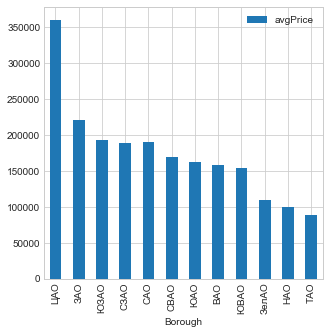

In [59]:
avg_estate_price_df = pd.read_csv('data/AvgBoroughPrice.csv')
avg_estate_price_df.columns = ['Borough', 'avgPrice']
avg_estate_price_df = avg_estate_price_df.set_index('Borough')
avg_estate_price_df.plot.bar(y='avgPrice', figsize=(5, 5))
plt.savefig('out/real_estate_price.png')

## Get average rent price by borough

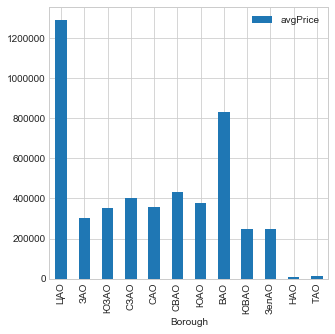

In [60]:
avg_rent_price = pd.read_csv('data/avgRentPrice.csv')
avg_rent_price.columns = ['Borough','avgPrice']
avg_rent_price = avg_rent_price.set_index('Borough')
avg_rent_price.plot.bar(y='avgPrice', figsize=(5, 5))
plt.savefig('out/average_rent_price_by_borough.png')

### Average mounthly income was collected my company (according to official Federal State of statistics).  
It has so difficult calculation (including statictic by regestered model of cars etc.). In this section is displayed only result

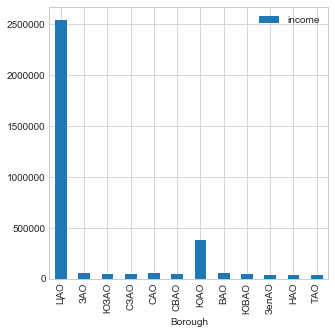

In [61]:
avg_income = pd.read_csv('data/avgIncome.csv')
avg_income.columns = ['Borough', 'income']
avg_income = avg_income.set_index('Borough')
avg_income.plot.bar(y='income', figsize=(5, 5))
plt.savefig('out/mounthly_income.png')

## Get nearby amusement  by Foursquare

In [62]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        jdata = requests.get(url).json()
        try:
            results = jdata["response"]['groups'][0]['items']
        except:
            continue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    return(nearby_venues)

In [63]:
file_name = 'data/foursquare_data.json'
one = df_districts_coords
radius = 500 
LIMIT = 100
if not os.path.exists(file_name):
    print('collection data....')
    res = getNearbyVenues(one['DistrictName'], one['lat'],one['lng'], radius = radius, LIMIT = LIMIT)
    res.to_json(file_name)
else:
    print('file exists')
    with io.open(file_name, 'r', encoding='utf8') as json_file:
        res = pd.DataFrame(json.loads(json_file.read()))

file exists


In [64]:
res.columns = ['DistrictName', 'lan', 'lng', 'PlaceName', 'lan1', 'lng1', 'PlaceType']
foursquare_df = res[['DistrictName', 'lan', 'lng', 'PlaceName', 'PlaceType']]
foursquare_df.head()

,DistrictName,lan,lng,PlaceName,PlaceType
0,Академический,55.688005,37.572684,Billy McDaniel,Pub
1,Академический,55.688005,37.572684,Здоров.ру,Pharmacy
10,Академический,55.688005,37.572684,Суши Wok,Sushi Restaurant
100,Арбат,55.751138,37.590003,Тирольские пироги,Dessert Shop
1000,Марфино,55.830002,37.588745,ENJOY,Bakery


## Get the nearest beer shops (by Yandex)

In [65]:
file_name = 'data/json_geo_venues.json'
if not os.path.exists(file_name):
    print('collection data....')
    coords = []
    for d_name in df_districts_coords.iterrows():
        name = d_name[1].DistrictName
        lat = d_name[1].lat
        lng = d_name[1].lng
        tcount = d_name[1].ResTotalCount
        url = 'https://search-maps.yandex.ru/v1/?text=Магазин%20пива&ll={},{}&lang=ru_RU&spn=0.03,0.03&apikey={}'.format(
            lng,
            lat,
            y_api_1
            )
        resp = requests.get(url)
        resp.encoding = 'utf-8'
        jpayload = json.loads(resp.text)
        coords.append({name:{'data':jpayload}})
    with io.open(file_name, 'w', encoding='utf8') as json_file:
        json.dump(coords, json_file, ensure_ascii=False)
else:
    print('file exists')
    with io.open(file_name, 'r', encoding='utf8') as json_file:
        coords = json.loads(json_file.read())

file exists


## Get beer shops by places

In [66]:
beer_shops = []
for item in coords:
    for key,val in item.items():
        for shop in val['data']['features']:
            shop_name = shop['properties']['name']
            beer_shops.append([key, shop_name])
beer_shops_df  = pd.DataFrame(beer_shops)
beer_shops_df.columns = ['DistrictName', 'BeerShop']

## Get total amusement places (exclude beer shops)

In [67]:
foursquare_no_shops_df = foursquare_df[~foursquare_df['PlaceName'].isin(beer_shops_df['BeerShop'])]
total_amus_places_df = foursquare_no_shops_df.groupby(['DistrictName']).count().reset_index()
total_amus_places_df = total_amus_places_df[['DistrictName', 'lan']]
total_amus_places_df.columns = ['DistrictName', 'TotoalAmusPlaces']

### Get total trademarks by places (Custormer decided to choose only these trademarks)

In [68]:
trademarks_df = pd.read_csv('data/Franchises.csv', delimiter =';')
beer_already_shops_df = beer_shops_df[beer_shops_df['BeerShop'].isin(trademarks_df['RussianName'])].reset_index()


### Get districts where trademarks is already present

In [69]:
beer_already_shops_df['already'] =  pd.DataFrame(np.ones(beer_already_shops_df.shape[0]).astype(int))
beer_already_shops_df = beer_already_shops_df[['DistrictName', 'already']]

## Set new Feature (count of beer shops / max beer shop per district)

In [70]:
beer_shops_by_district_df = beer_shops_df.groupby('DistrictName').count().reset_index()
beer_shops_by_district_df.columns = ['DistrictName', 'TotalFillness']
beer_shops_by_district_df['TotalFillness'] = beer_shops_by_district_df['TotalFillness'] / \
    beer_shops_by_district_df['TotalFillness'].max()

## Merge all the data in one DataFrame

In [71]:
df_districts_coords.head()

,DistrictName,ResTotalCount,Borough,lat,lng
0,Академический,109231,ЮЗАО,55.688005,37.572684
1,Алексеевский,80391,СВАО,55.812949,37.650163
2,Алтуфьевский,57408,СВАО,55.879849,37.582278
3,Арбат,35529,ЦАО,55.751138,37.590003
4,Аэропорт,79294,САО,55.803312,37.542599


In [72]:
beer_shops_by_district_df.head()

,DistrictName,TotalFillness
0,Академический,1.0
1,Алексеевский,1.0
2,Алтуфьевский,1.0
3,Арбат,0.7
4,Аэропорт,1.0


In [73]:
beer_already_shops_df.head()

,DistrictName,already
0,Братеево,1
1,Измайлово,1
2,Коньково,1
3,Кузьминки,1
4,Левобережный,1


In [74]:
estate_price_df = estate_price_df.reset_index()
estate_price_df.columns = ['DistrictName', 'avgPrice']
estate_price_df.head()

,DistrictName,avgPrice
0,Хамовники,778434.0
1,Арбат,709761.0
2,Якиманка,696347.0
3,Пресненский,591162.0
4,Тверской,569725.0


In [75]:
avg_estate_price_df.head()

,avgPrice
Borough,
ЦАО,360522
ЗАО,220656
ЮЗАО,193620
СЗАО,188357
САО,189633


In [76]:
avg_rent_price.head()

,avgPrice
Borough,
ЦАО,1293088
ЗАО,300111
ЮЗАО,350000
СЗАО,401000
САО,357444


In [77]:
avg_income.head()

,income
Borough,
ЦАО,2540000
ЗАО,59234
ЮЗАО,45000
СЗАО,40100
САО,55744


In [78]:
total_amus_places_df.head()

,DistrictName,TotoalAmusPlaces
0,Академический,41
1,Алексеевский,23
2,Алтуфьевский,14
3,Арбат,100
4,Аэропорт,12


In [79]:
final_data_df = pd.merge(df_districts_coords, beer_shops_by_district_df, on='DistrictName',  how='left')
final_data_df.head()

,DistrictName,ResTotalCount,Borough,lat,lng,TotalFillness
0,Академический,109231,ЮЗАО,55.688005,37.572684,1.0
1,Алексеевский,80391,СВАО,55.812949,37.650163,1.0
2,Алтуфьевский,57408,СВАО,55.879849,37.582278,1.0
3,Арбат,35529,ЦАО,55.751138,37.590003,0.7
4,Аэропорт,79294,САО,55.803312,37.542599,1.0


In [80]:
final_data_df = pd.merge(final_data_df, beer_already_shops_df, on='DistrictName', how='left')
final_data_df.fillna(0, inplace=True)
final_data_df['already'] = final_data_df['already'].astype(int)
final_data_df.head()

,DistrictName,ResTotalCount,Borough,lat,lng,TotalFillness,already
0,Академический,109231,ЮЗАО,55.688005,37.572684,1.0,0
1,Алексеевский,80391,СВАО,55.812949,37.650163,1.0,0
2,Алтуфьевский,57408,СВАО,55.879849,37.582278,1.0,0
3,Арбат,35529,ЦАО,55.751138,37.590003,0.7,0
4,Аэропорт,79294,САО,55.803312,37.542599,1.0,0


In [81]:
df = pd.merge(final_data_df, avg_estate_price_df, on='Borough', how='left')
df = pd.merge(df, estate_price_df, on=['DistrictName'], how='left')
df['avgPrice'] = df['avgPrice_y'].where(df['avgPrice_y'].notna(),df['avgPrice_x'])
final_data_df = df[['DistrictName','ResTotalCount','Borough','lat','lng','TotalFillness','already','avgPrice']]
final_data_df.head()

,DistrictName,ResTotalCount,Borough,lat,lng,TotalFillness,already,avgPrice
0,Академический,109231,ЮЗАО,55.688005,37.572684,1.0,0,259369.0
1,Алексеевский,80391,СВАО,55.812949,37.650163,1.0,0,236290.0
2,Алтуфьевский,57408,СВАО,55.879849,37.582278,1.0,0,173135.0
3,Арбат,35529,ЦАО,55.751138,37.590003,0.7,0,709761.0
4,Аэропорт,79294,САО,55.803312,37.542599,1.0,0,253142.0


In [82]:
final_data_df = pd.merge(final_data_df, avg_rent_price, on='Borough', how='left', suffixes = ('', '_rent'))
final_data_df.head()

,DistrictName,ResTotalCount,Borough,lat,lng,TotalFillness,already,avgPrice,avgPrice_rent
0,Академический,109231,ЮЗАО,55.688005,37.572684,1.0,0,259369.0,350000
1,Алексеевский,80391,СВАО,55.812949,37.650163,1.0,0,236290.0,432333
2,Алтуфьевский,57408,СВАО,55.879849,37.582278,1.0,0,173135.0,432333
3,Арбат,35529,ЦАО,55.751138,37.590003,0.7,0,709761.0,1293088
4,Аэропорт,79294,САО,55.803312,37.542599,1.0,0,253142.0,357444


In [83]:
final_data_df = pd.merge(final_data_df, avg_income, on='Borough', how='left')
final_data_df.head()

,DistrictName,ResTotalCount,Borough,lat,lng,TotalFillness,already,avgPrice,avgPrice_rent,income
0,Академический,109231,ЮЗАО,55.688005,37.572684,1.0,0,259369.0,350000,45000
1,Алексеевский,80391,СВАО,55.812949,37.650163,1.0,0,236290.0,432333,45423
2,Алтуфьевский,57408,СВАО,55.879849,37.582278,1.0,0,173135.0,432333,45423
3,Арбат,35529,ЦАО,55.751138,37.590003,0.7,0,709761.0,1293088,2540000
4,Аэропорт,79294,САО,55.803312,37.542599,1.0,0,253142.0,357444,55744


In [84]:
final_data_df = pd.merge(final_data_df, total_amus_places_df, on='DistrictName', how='left')
final_data_df['TotoalAmusPlaces'].fillna((final_data_df['TotoalAmusPlaces'].mean()), inplace=True)
final_data_df['TotoalAmusPlaces'] = final_data_df['TotoalAmusPlaces'].astype(int)

In [85]:
final_data_df.head()

,DistrictName,ResTotalCount,Borough,lat,lng,TotalFillness,already,avgPrice,avgPrice_rent,income,TotoalAmusPlaces
0,Академический,109231,ЮЗАО,55.688005,37.572684,1.0,0,259369.0,350000,45000,41
1,Алексеевский,80391,СВАО,55.812949,37.650163,1.0,0,236290.0,432333,45423,23
2,Алтуфьевский,57408,СВАО,55.879849,37.582278,1.0,0,173135.0,432333,45423,14
3,Арбат,35529,ЦАО,55.751138,37.590003,0.7,0,709761.0,1293088,2540000,100
4,Аэропорт,79294,САО,55.803312,37.542599,1.0,0,253142.0,357444,55744,12


## Detect clusters of districts

In [86]:
data_df = final_data_df[['ResTotalCount', 'TotalFillness', 'already', 'avgPrice', \
    'avgPrice_rent', 'income', 'TotoalAmusPlaces']]

In [87]:
kclusters = 5
# run k-means algorithm
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_df)
klabels = kmeans.labels_

In [88]:
final_data_df['cluster'] = klabels

## Plot cluster map

In [89]:
msk_lat = 55.755814
msk_lng = 37.617635
map_clusters = folium.Map(location=[msk_lat, msk_lng], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_data_df['lat'], final_data_df['lng'], final_data_df['DistrictName'], final_data_df['cluster'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [90]:
map_clusters.save("out/moscow_map_clusters.html")